# Sebastian Garcia
# LSTM for financial time series forecasting

In [1]:
# Run this cell to activate your Google Drive account.
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

#Normalize Data and split  in Train and Test set
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# To run the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import math

#Plot
from matplotlib import pyplot as plt


In [0]:
path = 'drive/My Drive/Colab Notebooks/'
df = pd.read_csv(path+'binance_1min_labeled.csv', index_col=0)


In [4]:
df.head()


,time,btcusdt_open,btcusdt_high,btcusdt_low,btcusdt_close,btcusdt_vol,btcusdt_seller,btcusdt_buyer,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_vol,ethusdt_seller,ethusdt_buyer,ltcbtc_open,ltcbtc_high,ltcbtc_low,ltcbtc_close,ltcbtc_vol,ltcbtc_seller,ltcbtc_buyer,label
50000,1505942400,3961.03,3961.03,3961.02,3961.02,0.630300,0,5,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013298,0.013305,0.013298,0.013305,7.29,3.0,10.0,0.0
50001,1505942460,3961.03,3961.03,3961.02,3961.02,0.000000,0,0,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013305,0.013352,0.013305,0.013349,14.05,6.0,7.0,0.0
50002,1505942520,3961.03,3961.03,3961.02,3961.02,0.000000,0,0,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013349,0.013352,0.013349,0.013352,3.35,1.0,5.0,0.0
50003,1505942580,3961.03,3961.03,3961.02,3961.02,0.000000,0,0,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013352,0.013352,0.013349,0.013352,4.25,3.0,3.0,0.0
50004,1505942640,3975.94,3975.94,3962.18,3962.18,0.019624,2,2,288.00,288.00,288.00,288.00,0.02,0.0,1.0,0.013352,0.013352,0.013349,0.013349,19.48,2.0,4.0,0.0


In [5]:
df.tail()


,time,btcusdt_open,btcusdt_high,btcusdt_low,btcusdt_close,btcusdt_vol,btcusdt_seller,btcusdt_buyer,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_vol,ethusdt_seller,ethusdt_buyer,ltcbtc_open,ltcbtc_high,ltcbtc_low,ltcbtc_close,ltcbtc_vol,ltcbtc_seller,ltcbtc_buyer,label
649995,1541942100,6424.00,6426.09,6424.00,6424.37,2.284881,44,29,212.72,212.75,212.70,212.72,46.79162,21.0,20.0,0.008059,0.008059,0.008058,0.008058,3.49,0.0,3.0,0.0
649996,1541942160,6424.37,6424.37,6424.00,6424.37,3.336172,39,30,212.71,212.82,212.64,212.72,52.11829,21.0,15.0,0.008061,0.008064,0.008061,0.008064,3.65,3.0,0.0,0.0
649997,1541942220,6424.37,6426.08,6424.37,6424.41,2.554746,19,26,212.72,212.79,212.72,212.74,50.06029,12.0,28.0,0.008064,0.008068,0.008058,0.008058,47.96,3.0,8.0,0.0
649998,1541942280,6424.88,6426.53,6424.43,6426.12,6.557832,27,35,212.74,212.81,212.71,212.81,47.79095,21.0,9.0,0.008062,0.008065,0.008060,0.008064,28.10,2.0,4.0,0.0
649999,1541942340,6426.53,6428.21,6426.00,6426.00,2.577673,12,54,212.82,212.87,212.77,212.81,37.79858,12.0,15.0,0.008067,0.008067,0.008063,0.008063,0.14,1.0,1.0,0.0


  #### Project - You have been provided with crypto trading data, use that to prepare a LSTM model to predict closing/opening price of your favorite crypto-currency
  
      ○ **Goal 1** - Univariate predictions - Select one currency (e.g. Ethereum) and either 
      closing or opening price. Use that to prepare your training data and make a single cell LSTM 
      model.

**Analyzing Data**

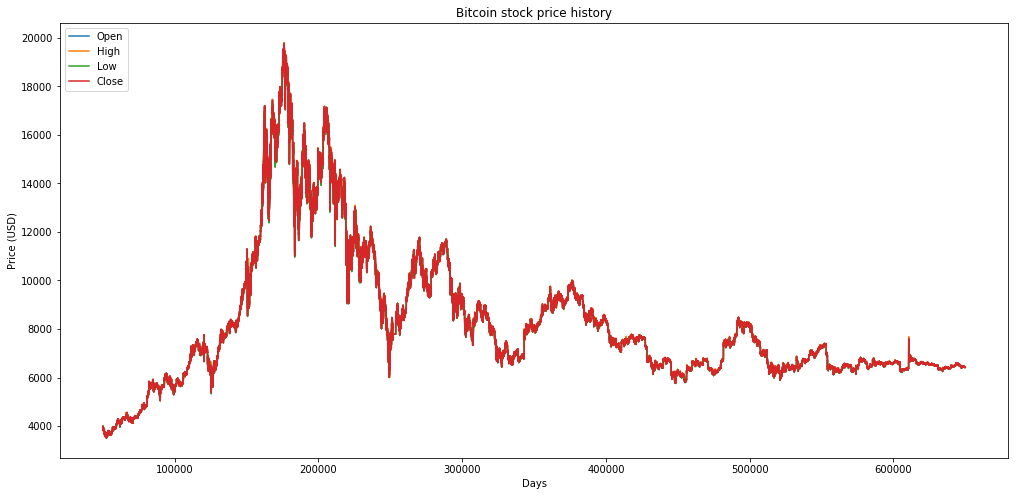

In [6]:
# Bitcoin
plt.figure(figsize=(17, 8))
plt.plot(df['btcusdt_open'])
plt.plot(df['btcusdt_high'])
plt.plot(df['btcusdt_low'])
plt.plot(df['btcusdt_close'])
plt.title('Bitcoin stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()


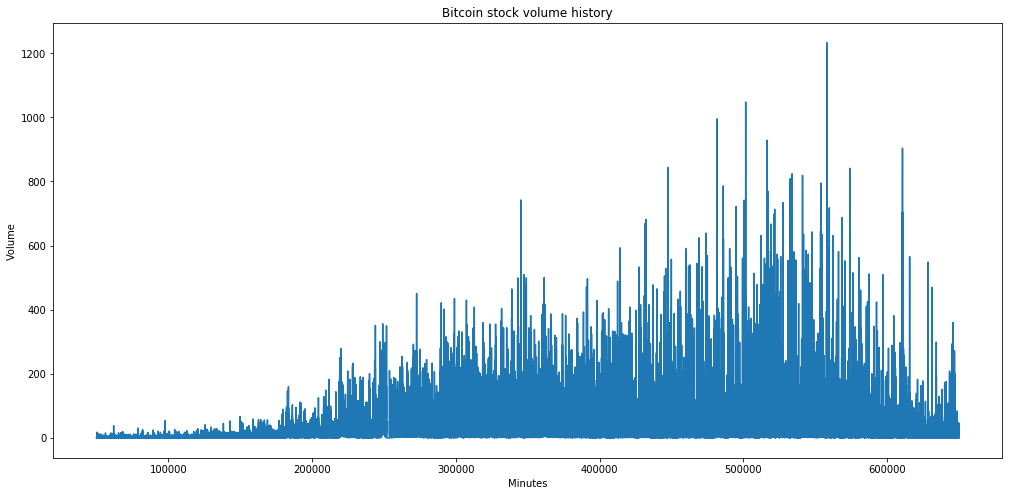

In [7]:
# Plot the volume
plt.figure(figsize=(17, 8))
plt.plot(df['btcusdt_vol'])
plt.title('Bitcoin stock volume history')
plt.ylabel('Volume')
plt.xlabel('Minutes')
plt.show()


In [8]:
#Check for NaNs
df.isna().sum()


time              0
btcusdt_open      0
btcusdt_high      0
btcusdt_low       0
btcusdt_close     0
btcusdt_vol       0
btcusdt_seller    0
btcusdt_buyer     0
ethusdt_open      0
ethusdt_high      0
ethusdt_low       0
ethusdt_close     0
ethusdt_vol       0
ethusdt_seller    0
ethusdt_buyer     0
ltcbtc_open       0
ltcbtc_high       0
ltcbtc_low        0
ltcbtc_close      0
ltcbtc_vol        0
ltcbtc_seller     0
ltcbtc_buyer      0
label             0
dtype: int64

**Converting data to time-series**

In [0]:
df.index = pd.to_datetime(df['time'], unit='s')


In [10]:
df.head()


,time,btcusdt_open,btcusdt_high,btcusdt_low,btcusdt_close,btcusdt_vol,btcusdt_seller,btcusdt_buyer,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_vol,ethusdt_seller,ethusdt_buyer,ltcbtc_open,ltcbtc_high,ltcbtc_low,ltcbtc_close,ltcbtc_vol,ltcbtc_seller,ltcbtc_buyer,label
time,,,,,,,,,,,,,,,,,,,,,,,
2017-09-20 21:20:00,1505942400,3961.03,3961.03,3961.02,3961.02,0.630300,0,5,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013298,0.013305,0.013298,0.013305,7.29,3.0,10.0,0.0
2017-09-20 21:21:00,1505942460,3961.03,3961.03,3961.02,3961.02,0.000000,0,0,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013305,0.013352,0.013305,0.013349,14.05,6.0,7.0,0.0
2017-09-20 21:22:00,1505942520,3961.03,3961.03,3961.02,3961.02,0.000000,0,0,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013349,0.013352,0.013349,0.013352,3.35,1.0,5.0,0.0
2017-09-20 21:23:00,1505942580,3961.03,3961.03,3961.02,3961.02,0.000000,0,0,288.99,288.99,288.99,288.99,0.00,0.0,0.0,0.013352,0.013352,0.013349,0.013352,4.25,3.0,3.0,0.0
2017-09-20 21:24:00,1505942640,3975.94,3975.94,3962.18,3962.18,0.019624,2,2,288.00,288.00,288.00,288.00,0.02,0.0,1.0,0.013352,0.013352,0.013349,0.013349,19.48,2.0,4.0,0.0


**Normalizing the data**

In [0]:
df = df.head(60000) #We can not take a random sample because it is a time serie!


In [12]:
df.shape


(60000, 23)

In [13]:
#Split df into train and test
train_cols = ["btcusdt_open"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])


Train and Test size 48000 12000


**Prepare the data to run the LSTM Model**

In [0]:
'''This function will create a dataset where X is the opening price at a given 
time (t) and Y is the opening price at the next time (t + 1)'''

# convert an array of values into a dataset matrix
def create_df(df, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df)-look_back-1):
        a = df[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(df[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [0]:
# Prepare the train and test datasets for modeling.

# reshape into X=t and Y=t+1
look_back = 15 #number of previous time steps to use as input variables to predict the next time period
trainX, trainY = create_df(x_train, look_back)
testX, testY = create_df(x_test, look_back)


In [16]:
trainX, trainY


(array([[0.17045971, 0.17045971, 0.17045971, ..., 0.17089137, 0.17089137,
         0.17089137],
        [0.17045971, 0.17045971, 0.17045971, ..., 0.17089137, 0.17089137,
         0.17089137],
        [0.17045971, 0.17045971, 0.17605636, ..., 0.17089137, 0.17089137,
         0.17605636],
        ...,
        [0.76435105, 0.79174502, 0.80029579, ..., 0.79912465, 0.79911715,
         0.79728913],
        [0.79174502, 0.80029579, 0.79993544, ..., 0.79911715, 0.79728913,
         0.7918764 ],
        [0.80029579, 0.79993544, 0.80029203, ..., 0.79728913, 0.7918764 ,
         0.79692878]]),
 array([0.17089137, 0.17605636, 0.17605636, ..., 0.7918764 , 0.79692878,
        0.79724784]))

In [0]:
'''The LSTM network expects the input data (X) to be provided with a specific 
array structure in the form of: [samples, time steps, features].'''

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


**Creating LSTM model**

![texto alternativo](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # 4 is very low, I should try with 50, or run random and grid search and look for the optimum number of hiden layers.
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') # use rms as optimizer to see whats happend with the model
model.fit(trainX, trainY, epochs=5, batch_size=1, validation_data=(testX, testY), verbose=2)


W0703 11:49:19.013041 139929352865664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0703 11:49:19.431168 139929352865664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 47984 samples, validate on 11984 samples
Epoch 1/5
47984/47984 - 98s - loss: 2.3279e-04 - val_loss: 5.5699e-04
Epoch 2/5
47984/47984 - 98s - loss: 3.7610e-05 - val_loss: 8.8691e-04
Epoch 3/5
47984/47984 - 98s - loss: 3.2219e-05 - val_loss: 0.0012
Epoch 4/5
47984/47984 - 99s - loss: 3.0153e-05 - val_loss: 0.0012
Epoch 5/5
47984/47984 - 98s - loss: 2.9215e-05 - val_loss: 0.0012


In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY_unscaled = min_max_scaler.inverse_transform([trainY])
testPredict = min_max_scaler.inverse_transform(testPredict)
persistance_unscaled = min_max_scaler.inverse_transform(np.reshape(testX[:,0,-1],[1,-1]))
testY_unscaled = min_max_scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_unscaled[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_unscaled[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

'''Here we set our Y test = to the real values (same price as the real ones) 
and we compare how far is the real RMSE from the prediction'''
testScore = math.sqrt(mean_squared_error(testY_unscaled[0], persistance_unscaled[0]))
print('Test Score Persistance: %.2f RMSE' % (testScore))


Train Score: 11.70 RMSE
Test Score: 94.12 RMSE
Test Score Persistance: 9.63 RMSE


In [20]:
testY_unscaled.shape


(1, 11984)

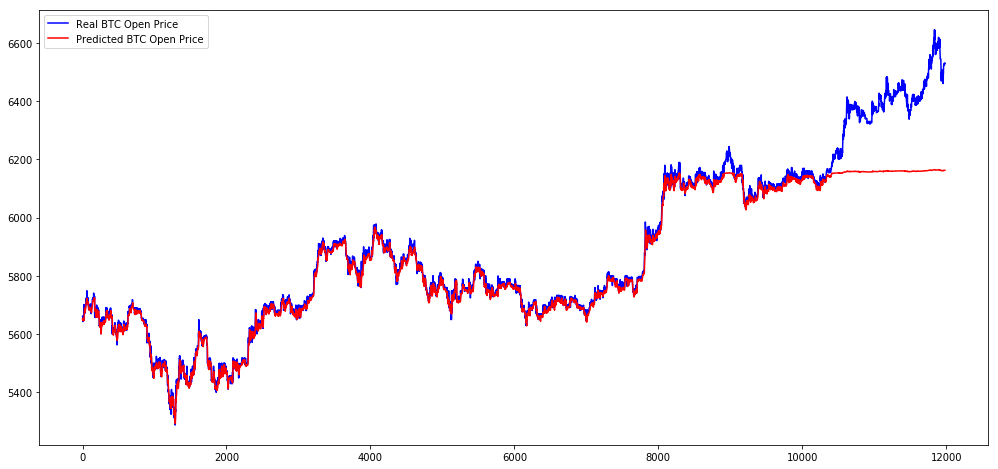

In [21]:
# plot real test set and predictions
plt.figure(figsize=(17, 8))
plt.plot(testY_unscaled[0], c='blue', label='Real BTC Open Price')
plt.plot(testPredict, c='red', label='Predicted BTC Open Price')
plt.legend()
plt.show()


As soon as the test set touch one it remains fixed, because the default activation function of the model is **tanh (hyperbolic tangent)** can not predict a value above 1.

In [22]:
np.array(testY_unscaled[0])


array([5660.98, 5659.98, 5660.99, ..., 6529.97, 6529.98, 6529.97])

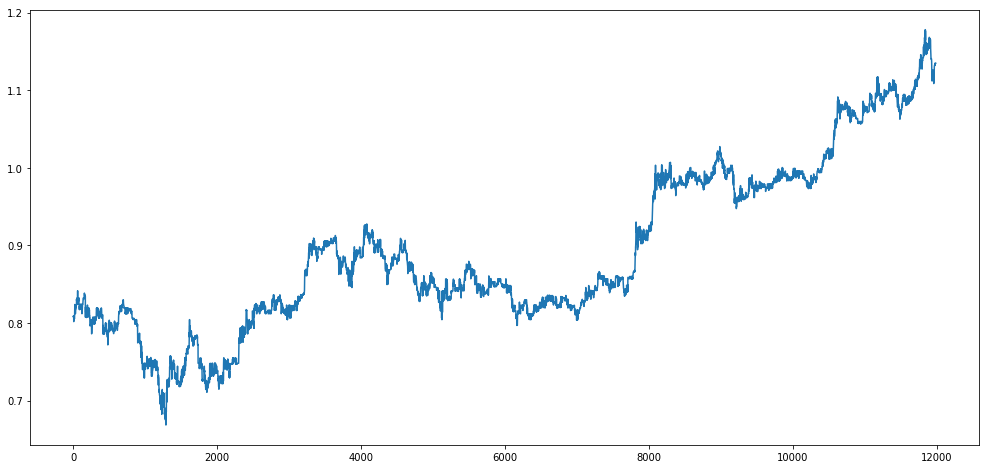

In [23]:
plt.figure(figsize=(17, 8))
plt.plot(testY)
